# Trial-Based Data and Mixed Parameter Types in SBI

**Time: ~15 minutes**

In many scientific applications, we observe **multiple data points per experiment** that are assumed to be independent and identically distributed (IID) given the same underlying parameters. For example:
- Decision-making experiments with repeated trials
- Neuroscience recordings across multiple sessions
- Repeated measurements in physics experiments

## What We'll Learn

1. **NLE for trial-based data**: Train on single trials, infer from multiple trials
2. **NPE with permutation-invariant embeddings**: Fully amortized inference over varying numbers of trials
3. **MNPE for mixed parameter types**: Handle continuous AND discrete parameters

**Key insight**: Different SBI methods handle trial-based data differently — NLE/NRE exploit IID structure automatically, while NPE requires special embedding networks!

**Documentation**: [sbi IID tutorial](https://sbi.readthedocs.io/en/latest/advanced_tutorials/12_iid_data_and_permutation_invariant_embeddings.html)

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np

from sbi.inference import NLE, NPE, MNPE
from sbi.analysis import pairplot
from sbi.neural_nets import posterior_nn
from sbi.neural_nets.embedding_nets import FCEmbedding, PermutationInvariantEmbedding
from sbi.inference.posteriors.posterior_parameters import MCMCPosteriorParameters

from simulators import (
    linear_gaussian_simulator,
    create_trial_data_prior,
    simulate_iid_trials,
    true_posterior_linear_gaussian,
    create_mixed_prior,
    mixed_simulator,
)

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

---
## Setup: A Simple Trial-Based Simulator

We use a **Linear Gaussian** model — the simplest possible simulator for learning:

$$\theta \sim \text{Uniform}(-2, 2)^2$$
$$x_i | \theta \sim \mathcal{N}(\theta, \sigma^2 I) \quad \text{for } i = 1, \ldots, N$$

Each trial $x_i$ is a noisy observation of the true parameter $\theta$. With more trials, we get more information about $\theta$, and the posterior becomes more concentrated.

In [2]:
# Setup
dim = 2  # 2D parameter space
noise_std = 0.5  # Observation noise
prior = create_trial_data_prior(dim=dim)

# True parameters for our "observed" data
theta_o = torch.tensor([0.5, -0.3])

print(f"Prior: Uniform over [-2, 2]^{dim}")
print(f"True parameters: θ = {theta_o.numpy()}")
print(f"Observation noise: σ = {noise_std}")

Prior: Uniform over [-2, 2]^2
True parameters: θ = [ 0.5 -0.3]
Observation noise: σ = 0.5


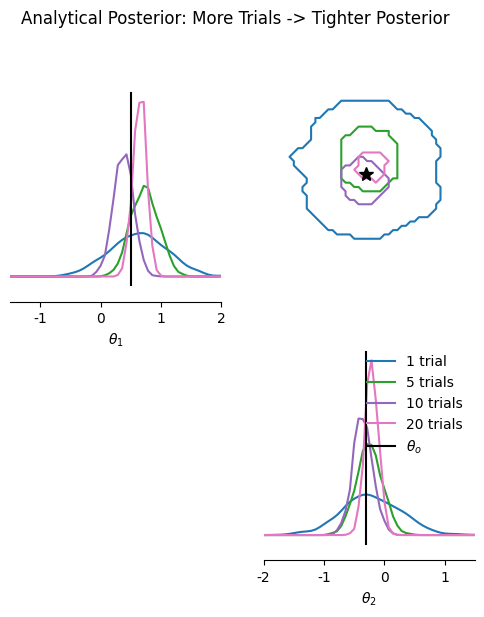

With more IID trials, the posterior concentrates around the true parameter!


In [3]:
# Visualize how the posterior concentrates with more trials
num_trials_list = [1, 5, 10, 20]

# Generate observed data with different numbers of trials
x_o_dict = {}
for nt in num_trials_list:
    x_o_dict[nt] = simulate_iid_trials(theta_o, num_trials=nt, noise_std=noise_std)

# Get analytical posterior samples for visualization
true_samples_dict = {}
for nt in num_trials_list:
    posterior = true_posterior_linear_gaussian(x_o_dict[nt], noise_std=noise_std)
    true_samples_dict[nt] = posterior.sample((1000,))

# Plot the analytical posteriors
fig, ax = pairplot(
    [true_samples_dict[nt] for nt in num_trials_list],
    points=theta_o.unsqueeze(0),
    diag="kde",
    upper="contour",
    labels=[r"$\theta_1$", r"$\theta_2$"],
    limits=[[-1.5, 2], [-2, 1.5]],
    upper_kwargs=dict(levels=[0.95]),
    fig_kwargs=dict(
        points_colors=["k"],
        points_offdiag=dict(marker="*", markersize=10),
    ),
    figsize=(6, 6),
)
plt.sca(ax[1, 1])
plt.legend(
    [f"{nt} trial{'s' if nt > 1 else ''}" for nt in num_trials_list] + [r"$\theta_o$"],
    frameon=False,
    fontsize=10,
)
plt.suptitle("Analytical Posterior: More Trials -> Tighter Posterior", y=1.02)
plt.show()

print("With more IID trials, the posterior concentrates around the true parameter!")

---
## Think First!

Before we implement inference, let's think about how different SBI methods handle IID data:

**Question 1**: In standard NPE, what is the input to the neural network? Why is this problematic for IID data?

**Question 2**: NLE estimates $p(x|\theta)$. How can we use this for inference with multiple IID observations?

**Question 3**: What property must an embedding network have to handle IID data with varying numbers of trials?

<details>
<summary>Click to reveal answers</summary>

1. **NPE input problem:**
   - NPE takes observation $x$ as input and outputs posterior parameters
   - If $x$ is a set of IID trials $\{x_1, ..., x_N\}$, the network needs:
     - Fixed input size (but N varies!)
     - Invariance to the order of trials (IID means order doesn't matter!)
   - Standard NPE can't handle this directly!

2. **NLE with IID data:**
   - Train NLE on **single trials** to learn $p(x|\theta)$
   - For IID data: $p(\{x_i\}|\theta) = \prod_i p(x_i|\theta)$ (or sum log-likelihoods)
   - The joint likelihood can then be used with MCMC/VI for inference
   - No retraining needed for different numbers of trials!

3. **Permutation invariance:**
   - The embedding must be **permutation invariant**: $f(\{x_1, x_2, x_3\}) = f(\{x_3, x_1, x_2\})$
   - Achieved by: embedding each trial separately, then aggregating (sum/mean)
   - Must also handle **variable-size** inputs for amortization over N

</details>

---
## Part 1: NLE for Trial-Based Data

**Neural Likelihood Estimation (NLE)** is naturally suited for IID data:

1. Train on **single-trial** data: Learn $p(x|\theta)$ for individual observations
2. At inference: Combine likelihoods across trials: $p(\{x_i\}|\theta) = \prod_i p(x_i|\theta)$
3. Use MCMC to sample from the posterior

**Key advantage**: Train once, infer with any number of trials!

In [4]:
# Generate single-trial training data for NLE
num_simulations = 1000

theta_train = prior.sample((num_simulations,))
x_train = linear_gaussian_simulator(theta_train, noise_std=noise_std)

print(f"Training data: {num_simulations} single-trial simulations")
print(f"theta shape: {theta_train.shape}, x shape: {x_train.shape}")

Training data: 1000 single-trial simulations
theta shape: torch.Size([1000, 2]), x shape: torch.Size([1000, 2])


### Your Task: Train NLE and perform inference with multiple trials

Complete the code below to:
1. Create and train an NLE model on single-trial data
2. Build a posterior and sample given 10 observed trials

**Hints**:
- Use `NLE(prior, density_estimator="mdn")` for the inference object
- Use `nle.append_simulations(theta, x).train()` to train
- For MCMC, we provide `mcmc_parameters` below
- Sample with `posterior.sample(sample_shape=(N,), x=x_o)`

In [5]:
# MCMC parameters for NLE inference
mcmc_parameters = MCMCPosteriorParameters(
    method="slice_np_vectorized",
    num_chains=20,
    thin=5,
    warmup_steps=50,
    init_strategy="proposal",
)

# SOLUTION (leave TODOs for students)
# TODO: Create NLE inference object
nle = NLE(prior, density_estimator="mdn")

# TODO: Train NLE on single-trial data
nle.append_simulations(theta_train, x_train).train()

# TODO: Build posterior with MCMC
posterior_nle = nle.build_posterior(posterior_parameters=mcmc_parameters)

print("NLE trained on single-trial data!")

 Neural network successfully converged after 70 epochs.NLE trained on single-trial data!


In [6]:
# Now sample from the posterior given 10 IID trials
num_trials_test = 10
x_o_10 = x_o_dict[10]  # 10 trials

print(f"Observed data shape: {x_o_10.shape} (10 trials, 2D each)")

# SOLUTION
# TODO: Sample from the posterior (sbi automatically handles IID data!)
samples_nle = posterior_nle.sample(sample_shape=(2000,), x=x_o_10)

print(f"Posterior samples shape: {samples_nle.shape}")

Observed data shape: torch.Size([10, 2]) (10 trials, 2D each)


Generating 20 MCMC inits via proposal strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/16000 [00:00<?, ?it/s]

Posterior samples shape: torch.Size([2000, 2])


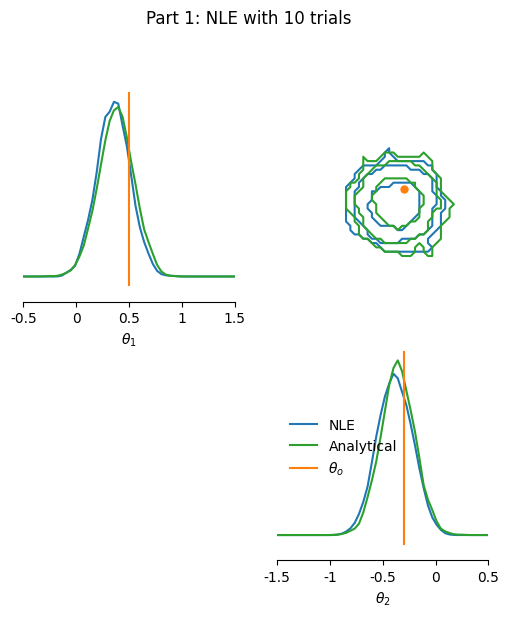

NLE successfully handles multiple IID trials without retraining!


In [7]:
# Compare NLE posterior with analytical posterior
true_posterior_10 = true_posterior_linear_gaussian(x_o_10, noise_std=noise_std)
samples_true_10 = true_posterior_10.sample((2000,))

fig, ax = pairplot(
    [samples_nle, samples_true_10],
    points=theta_o.unsqueeze(0),
    diag="kde",
    upper="contour",
    labels=[r"$\theta_1$", r"$\theta_2$"],
    limits=[[-0.5, 1.5], [-1.5, 0.5]],
    figsize=(6, 6),
)
plt.sca(ax[1, 1])
plt.legend(["NLE", "Analytical", r"$\theta_o$"], frameon=False)
plt.suptitle("Part 1: NLE with 10 trials", y=1.02)
plt.show()

print("NLE successfully handles multiple IID trials without retraining!")

---
## Part 2: NPE with Permutation-Invariant Embedding

For **fully amortized** inference over varying numbers of trials, we can use NPE with a **permutation-invariant embedding network**.

The idea:
1. **Single-trial embedding**: A network that embeds each trial $x_i$ into a latent space
2. **Aggregation**: Combine embeddings via a permutation-invariant operation (e.g., mean/sum)

**Trade-off**: NPE requires training on data with varying numbers of trials, but inference is instant (no MCMC)!

### Training data construction

To train NPE to be amortized over the number of trials, we need to:
1. For each parameter set, simulate data with **varying** numbers of trials
2. Pad missing trials with NaN (so all training examples have the same shape)
3. Use `z_score_x="none"` because NaN values interfere with z-scoring

In [8]:
# Generate training data with varying numbers of trials
max_num_trials = 20
num_training_samples = 1000

# Sample base parameters
theta_base = prior.sample((num_training_samples,))

# Create training data: for each parameter set, create examples with 1, 2, ..., max_num_trials trials
# Unobserved trials are masked with NaN
x_npe = torch.ones(num_training_samples * max_num_trials, max_num_trials, dim) * float("nan")

for i in range(num_training_samples):
    # Simulate max_num_trials trials for this parameter
    xi = linear_gaussian_simulator(theta_base[i].repeat(max_num_trials, 1), noise_std=noise_std)
    # Create training examples with varying numbers of trials
    for j in range(max_num_trials):
        x_npe[i * max_num_trials + j, :j + 1, :] = xi[:j + 1, :]

# Repeat theta to match
theta_npe = theta_base.repeat_interleave(max_num_trials, dim=0)

print(f"Training data shapes:")
print(f"  theta: {theta_npe.shape}")
print(f"  x: {x_npe.shape} (batch, max_trials, dim)")

Training data shapes:
  theta: torch.Size([20000, 2])
  x: torch.Size([20000, 20, 2]) (batch, max_trials, dim)


### Your Task: Build and train NPE with permutation-invariant embedding

Complete the code below to:
1. Create a `PermutationInvariantEmbedding` network
2. Build a density estimator with this embedding
3. Train NPE and sample from the posterior

**The key components**:
```python
# 1. Single-trial embedding network
single_trial_net = FCEmbedding(input_dim=..., output_dim=...)

# 2. Permutation-invariant wrapper
embedding_net = PermutationInvariantEmbedding(
    single_trial_net,
    trial_net_output_dim=...,  # Must match single_trial_net output
    output_dim=...,            # Final embedding size
)

# 3. Create density estimator with embedding
density_estimator = posterior_nn("mdn", embedding_net=..., z_score_x="none")
```

**Note**: We use `z_score_x="none"` because NaN padding interferes with z-scoring.

In [9]:
# SOLUTION (leave TODOs for students)
# Build the permutation-invariant embedding network
latent_dim = 10

# TODO: Create single-trial embedding network
single_trial_net = FCEmbedding(
    input_dim=dim,  # Each trial is 2D
    num_hiddens=40,
    num_layers=2,
    output_dim=latent_dim,
)

# TODO: Wrap in permutation-invariant embedding
embedding_net = PermutationInvariantEmbedding(
    single_trial_net,
    trial_net_output_dim=latent_dim,
    num_layers=1,
    num_hiddens=10,
    output_dim=10,
)

# TODO: Create density estimator with embedding
density_estimator = posterior_nn(
    "mdn",
    embedding_net=embedding_net,
    z_score_x="none",  # Important: NaN padding breaks z-scoring!
)

print("Permutation-invariant embedding network created!")

Permutation-invariant embedding network created!


In [10]:
# Train NPE with the permutation-invariant embedding
# SOLUTION
# TODO: Create NPE with the custom density estimator
npe = NPE(prior, density_estimator=density_estimator)

# TODO: Train (exclude_invalid_x=False because we use NaN padding)
npe.append_simulations(theta_npe, x_npe, exclude_invalid_x=False).train(
    training_batch_size=1000
)

# TODO: Build posterior
posterior_npe = npe.build_posterior()

print("NPE with permutation-invariant embedding trained!")

 Neural network successfully converged after 183 epochs.NPE with permutation-invariant embedding trained!


In [11]:
# Sample from the posterior given 10 IID trials
# We need to pad the observation to match the training format
x_o_padded = torch.ones(1, max_num_trials, dim) * float("nan")
x_o_padded[0, :num_trials_test, :] = x_o_10

# SOLUTION
# TODO: Sample from NPE posterior
samples_npe_perm = posterior_npe.sample((2000,), x=x_o_padded)

print(f"Posterior samples shape: {samples_npe_perm.shape}")

  0%|          | 0/2000 [00:00<?, ?it/s]

Posterior samples shape: torch.Size([2000, 2])


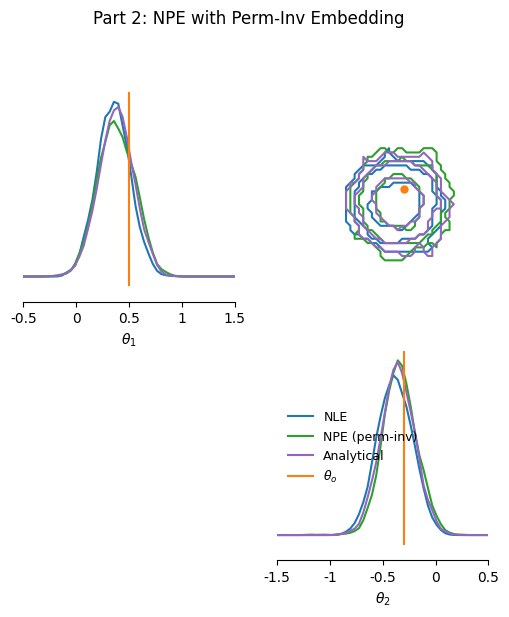

NPE is fully amortized - instant inference for any number of trials (up to max_num_trials)!


In [12]:
# Compare all methods
fig, ax = pairplot(
    [samples_nle, samples_npe_perm, samples_true_10],
    points=theta_o.unsqueeze(0),
    diag="kde",
    upper="contour",
    labels=[r"$\theta_1$", r"$\theta_2$"],
    limits=[[-0.5, 1.5], [-1.5, 0.5]],
    figsize=(6, 6),
)
plt.sca(ax[1, 1])
plt.legend(["NLE", "NPE (perm-inv)", "Analytical", r"$\theta_o$"], frameon=False, fontsize=9)
plt.suptitle("Part 2: NPE with Perm-Inv Embedding", y=1.02)
plt.show()

print("NPE is fully amortized - instant inference for any number of trials (up to max_num_trials)!")

---
## Part 3: MNPE for Mixed Parameter Types

What if your model has both **continuous** AND **discrete** parameters?

Examples:
- Model selection (discrete) + model parameters (continuous)
- Binary switches + tuning parameters
- Categorical choices + real-valued settings

**MNPE (Mixed Neural Posterior Estimation)** extends NPE to handle this!

### The Mixed Simulator

We use a simple simulator with:
- $\theta_1 \in \mathbb{R}$: Continuous parameter (Gaussian prior)
- $\theta_2, \theta_3 \in \{0, 1\}$: Binary discrete parameters (Bernoulli prior)

The observations are:
- $x_1 = \theta_1 + \epsilon_1$ where $\epsilon_1 \sim \mathcal{N}(0, 0.1^2)$
- $x_2 = \theta_2 + \theta_3 + \epsilon_2$ where $\epsilon_2 \sim \mathcal{N}(0, 0.01^2)$

**Key**: $x_2$ depends on the **sum** of discrete parameters, so $(0,1)$ and $(1,0)$ produce similar observations!

In [13]:
# Setup for MNPE
dim_continuous = 1
dim_discrete = 2

# Create mixed prior (continuous must come first for MNPE!)
mixed_prior = create_mixed_prior(dim_continuous=dim_continuous, dim_discrete=dim_discrete)

# True parameters for observation
theta_o_mixed = torch.tensor([[0.5, 0.0, 1.0]])  # continuous=0.5, discrete=(0,1)
x_o_mixed = mixed_simulator(theta_o_mixed)

print(f"True parameters: θ = {theta_o_mixed[0].numpy()}")
print(f"  - Continuous (θ₁): {theta_o_mixed[0, 0].item():.2f}")
print(f"  - Discrete (θ₂, θ₃): ({int(theta_o_mixed[0, 1].item())}, {int(theta_o_mixed[0, 2].item())})")
print(f"Observation: x = {x_o_mixed[0].numpy()}")
print(f"  - x₁ ≈ θ₁ = {x_o_mixed[0, 0].item():.3f}")
print(f"  - x₂ ≈ θ₂ + θ₃ = {x_o_mixed[0, 1].item():.3f}")

True parameters: θ = [0.5 0.  1. ]
  - Continuous (θ₁): 0.50
  - Discrete (θ₂, θ₃): (0, 1)
Observation: x = [0.4626936 0.994346 ]
  - x₁ ≈ θ₁ = 0.463
  - x₂ ≈ θ₂ + θ₃ = 0.994


### Your Task: Train MNPE and perform inference

Complete the code below to:
1. Generate training data with the mixed simulator
2. Create and train an MNPE model
3. Sample from the posterior and compare with analytical

**Key syntax**:
```python
# Create MNPE density estimator
density_estimator = posterior_nn(model="mnpe", hidden_features=..., num_transforms=...)

# Create inference object
inference = MNPE(density_estimator=density_estimator)
```

In [14]:
# Generate training data for MNPE
num_simulations_mnpe = 5000

# SOLUTION
# TODO: Sample from mixed prior
theta_mnpe = mixed_prior.sample((num_simulations_mnpe,))

# TODO: Simulate observations
x_mnpe = mixed_simulator(theta_mnpe)

print(f"Training data shapes: theta={theta_mnpe.shape}, x={x_mnpe.shape}")

Training data shapes: theta=torch.Size([5000, 3]), x=torch.Size([5000, 2])


In [15]:
# Create and train MNPE
# SOLUTION
# TODO: Create MNPE density estimator
density_estimator_mnpe = posterior_nn(
    model="mnpe",
    hidden_features=10,
    num_transforms=3,
)

# TODO: Create MNPE inference object
mnpe = MNPE(density_estimator=density_estimator_mnpe)

# TODO: Train MNPE
mnpe.append_simulations(theta_mnpe, x_mnpe).train()

# TODO: Build posterior
posterior_mnpe = mnpe.build_posterior()

print("MNPE trained!")

/mnt/lustre/work/macke/mwe054/repos/sbi-hackathon-2026/.venv/lib/python3.12/site-packages/sbi/neural_nets/net_builders/mixed_nets.py:260: UserWarning: The mixed neural density estimator assumes that x contains continuous data in the first n-k columns (e.g., reaction times) and categorical data in the last k columns (e.g., corresponding choices). If this is not the case for the passed `x` do not use this function.
  return _build_mixed_density_estimator(
/mnt/lustre/work/macke/mwe054/repos/sbi-hackathon-2026/.venv/lib/python3.12/site-packages/sbi/neural_nets/net_builders/mixed_nets.py:163: UserWarning: Inferring num_categories from batch_x. Ensure all categories are present.
  discrete_net = build_categoricalmassestimator(


 Neural network successfully converged after 71 epochs.MNPE trained!


In [16]:
# Sample from MNPE posterior
num_samples = 10000

# SOLUTION
# TODO: Sample from MNPE posterior
samples_mnpe = posterior_mnpe.sample((num_samples,), x=x_o_mixed, show_progress_bars=False)

print(f"MNPE samples shape: {samples_mnpe.shape}")

MNPE samples shape: torch.Size([10000, 3])


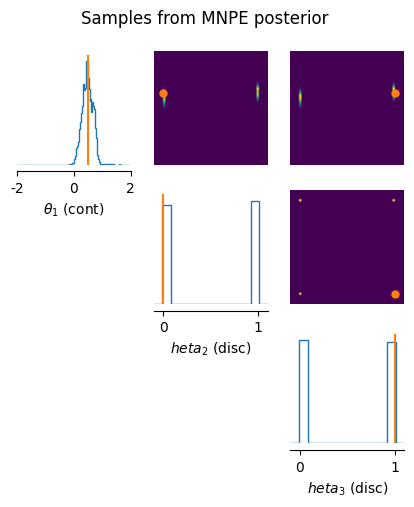

In [17]:
# Compare MNPE with analytical posterior
# Following the toy.ipynb style: separate pairplots

# MNPE posterior
_ = pairplot(
    samples_mnpe,
    points=theta_o_mixed,
    limits=[[-2, 2]] * dim_continuous + [[-0.1, 1.1]] * dim_discrete,
    labels=[r"$\theta_1$ (cont)"] + [f"$\theta_{i+2}$ (disc)" for i in range(dim_discrete)],
    figsize=(5, 5),
)
plt.suptitle("Samples from MNPE posterior")
plt.show()

---
## Summary

### Methods for Trial-Based Data

| Method | Training Data | Inference | Pros | Cons |
|--------|--------------|-----------|------|------|
| **NLE** | Single trials | MCMC | Simple training, flexible | Requires MCMC per observation |
| **NPE + Perm-Inv** | Varying #trials | Forward pass | Fully amortized | More complex training data |

### MNPE for Mixed Parameters

| Feature | Standard NPE | MNPE |
|---------|-------------|------|
| Continuous parameters | ✓ | ✓ |
| Discrete parameters | ✗ | ✓ |
| Mixed types | ✗ | ✓ |

### Key Takeaways

1. **NLE is naturally suited for IID data**: Train on single trials, multiply likelihoods at inference
2. **NPE needs special handling**: Use `PermutationInvariantEmbedding` for amortization over trials
3. **MNPE extends NPE to mixed types**: Handles both continuous and discrete parameters
4. **Trade-offs exist**: NLE is simpler to train but requires MCMC; NPE with embeddings is fully amortized but needs more complex training data

---
## Learning Goals

After this notebook, you should be able to:

- Explain how NLE exploits the IID structure of trial-based data
- Use `PermutationInvariantEmbedding` for NPE with varying numbers of trials
- Apply MNPE for inference with mixed continuous and discrete parameters
- Choose the appropriate SBI method for different data structures